In [178]:
import sys

sys.path.append('../generate_dataset')
sys.path.append('../Siamese')
import SiameseNet
from pytorch_fast_elmo import FastElmo, batch_to_char_ids
import matplotlib.pyplot as plt
import random
import torch
from typing import List
import numpy as np
import utils
import termcolor

import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans  
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from collections import defaultdict
import spacy
import copy

In [176]:
class Vector(object):
    
    def __init__(self, vec, sentence, index):
        
        self.vec = vec
        self.sentence = sentence
        self.index = index
        self.size = np.linalg.norm(self.vec)
    
    def get_word(self):
        
        return self.sentence[self.index]
    
    def get_vector(self): 
        
        return self.vec
    
    def get_sentence(self):
        
        return self.sentence
    
    def get_index(self):
        
        return self.index
    
    def get_size(self):
        
        return self.size
    
    def __str__(self):
        
        words = self.get_sentence()
        i = self.get_index()
        before = " ".join(words[:i])
        after = " ".join(words[i + 1:])
        word = "***"+termcolor.colored(self.get_word(), "blue", attrs = ['bold'])+"***"
        sent = '""' + before + " " + word + " " + after + '"' + "***WORD: {} ***".format(self.get_word())
        return sent
    
    def similarity(self, other):
        
        if other is self: return -np.inf
        
        return self.get_vector().dot(other.get_vector())/(self.get_size() * other.get_size())
    
    @staticmethod
    def get_closest_vector(vec, vecs):
    
        closest = max(vecs, key = lambda vector: vector.similarity(vec))
        return closest

    
def cluster(vecs: List[Vector]):
    
    clust2vecs = defaultdict(list)
    only_vectors = [v.get_vector() for v in vecs]
    
    kmeans = KMeans(n_clusters = 300)
    kmeans.fit(only_vectors)  
    labels = kmeans.labels_
    
    for label, vector in zip(labels, vecs):
        
        clust2vecs[label].append(vector)
    
    return clust2vecs, only_vectors, labels

def plot(only_vectors, labels):
    
    proj = TSNE(n_components=2).fit_transform(only_vectors)
    fig, ax = plt.subplots()
    plt.scatter(proj[:,0], proj[:,1], c =labels, cmap='rainbow', alpha = 0.2)
    
def load_sents(fname = "sents_f", max_length = 15):
    
    with open(fname, "r") as f:
              
        lines = f.readlines()
    
    lines =  [line.strip().split(" ") for line in lines]
    if max_length is not None:
        lines = list(filter(lambda sentence: len(sentence) < max_length, lines))
    return lines

def load_model(name = "model.pt"):
    net = SiameseNet.SiameseNet()
    net.load_state_dict(torch.load(name))
    net.eval()
    return net

def list_vectors(vecs, sents: List[List[str]]) -> List[Vector]:
    
    num_sentences = len(sents)
    sents_indices_and_vecs =  zip(range(num_sentences), vecs)
    all_vectors = []

    for sent_index, sent_vectors in sents_indices_and_vecs:
        
        for i, (w,vec) in enumerate(zip(sents[sent_index], vecs[sent_index])):   
            
            v = Vector(vec.detach().numpy(), sents[sent_index], i)
            all_vectors.append(v)
            
    return all_vectors

def transform(model, vector: Vector):
    
    vec_pytorch = torch.from_numpy(vector.get_vector()).float()
    vector.vec = model._represent(vec_pytorch).detach().numpy()
    
def parse(sentences: List[List[str]]):
                                              
    tokens_dict = {" ".join(sentence):sentence for sentence in sentences}
    def custom_tokenizer(text): return tokens_dict[text]
    nlp = spacy.load('en_core_web_sm')
    #parser = nlp.create_pipe("parser")

    all_deps = []
    count = 0
    
    for sent in sentences:
        
        doc = spacy.tokens.Doc(vocab=nlp.vocab, words=sent)
        for name, proc in nlp.pipeline:             # iterate over components in order
            doc = proc(doc)
  
        deps = [token.dep_ for token in doc]
        count += len(deps)
        
        if len(deps) == len(sent):
            all_deps.extend(deps)
    
    print(count)
    return all_deps

def plot_heatmap(deps, clusts):
    
    deps_set = list(set(deps))
    clusts_set = list(set(clusts))
    deps2ind, ind2dep = {d:i for i,d in enumerate(deps_set)}, {i:d for i,d in enumerate(deps_set)}
    cooccurrences = np.zeros((len(deps_set), len(clusts_set)))
    
    for d,c in zip(deps, clusts):
        
        d_ind = deps2ind[d]
        cooccurrences[d_ind][c] += 1
    
    cooccurrences /= cooccurrences.sum(axis=1, keepdims=True)
    fig=plt.figure(figsize=(28, 16), dpi= 80, facecolor='w', edgecolor='k')
    fig, ax1 = plt.subplots(1,1, figsize=(68, 56), dpi= 80)

    ax1.imshow(cooccurrences, cmap='hot', interpolation='none')
    plt.yticks(range(len(deps_set)))
    ax1.set_yticklabels([''] + deps_set)
    
    plt.show()    

In [75]:
all_sentences = load_sents(max_length = 15)
all_sentences = [sent for sent in all_sentences if len(sent) == 14]
options_file = "../generate_dataset/" + utils.DEFAULT_PARAMS["elmo_options"]
weight_file = "../generate_dataset/" + utils.DEFAULT_PARAMS["elmo_weights"]
elmo = FastElmo(options_file, weight_file)

In [145]:
N = 1000
sentences = all_sentences[:N]
character_ids = batch_to_char_ids(sentences)
embeddings = elmo(character_ids) # collect elmo states
network = load_model()


In [179]:
vecs_original = list_vectors(embeddings["elmo_representations"][0], sentences)
vecs_transformed = copy.deepcopy(vecs_original)

for v in vecs_transformed:
    transform(network, v)

In [180]:
_, _, labels_original = cluster(vecs_original)
_, _, labels_transformed = cluster(vecs_transformed)

In [149]:
deps = parse(sentences)

14000
14000 14000


### ***First, plot occurrences of the original vectors.***

<Figure size 2240x1280 with 0 Axes>

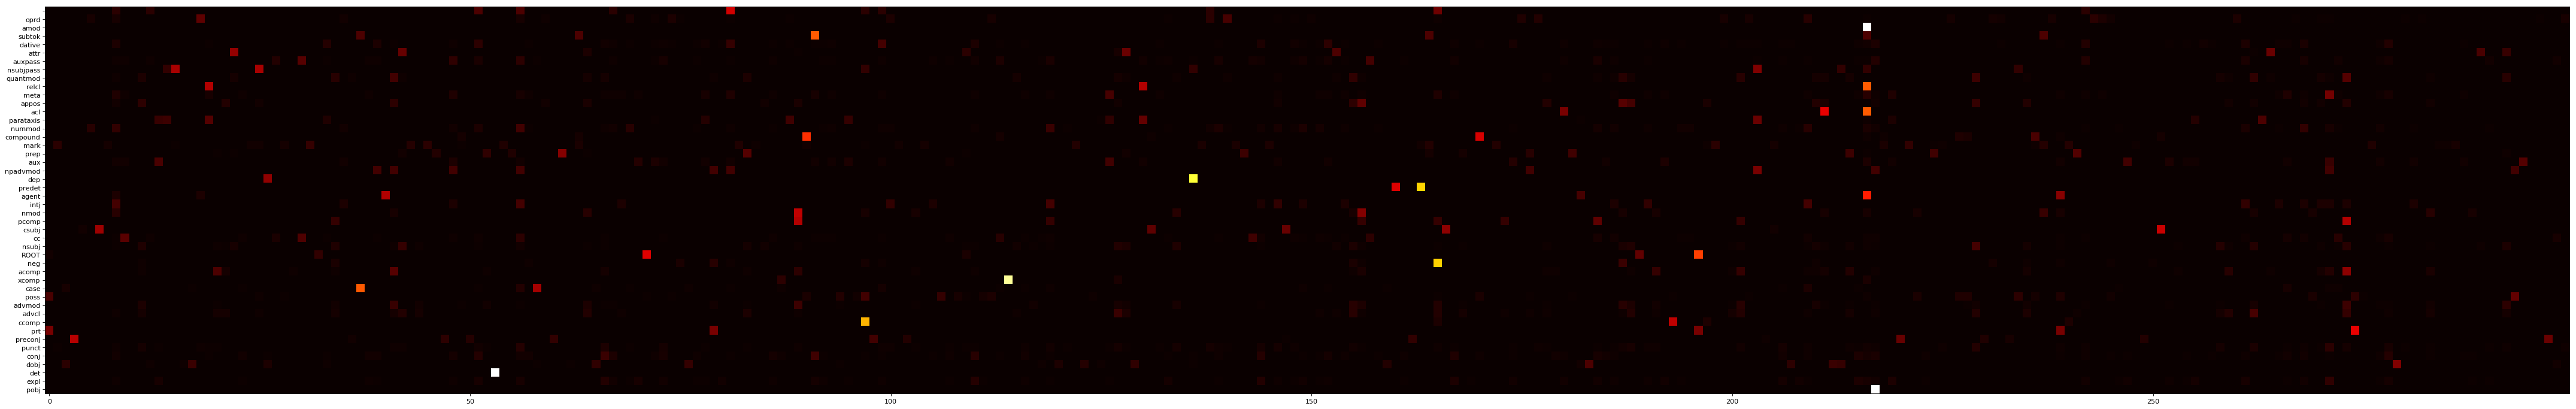

In [181]:
plot_heatmap(deps, labels_original)

### ***Now, plot occurrences of the transformed vectors.****

<Figure size 2240x1280 with 0 Axes>

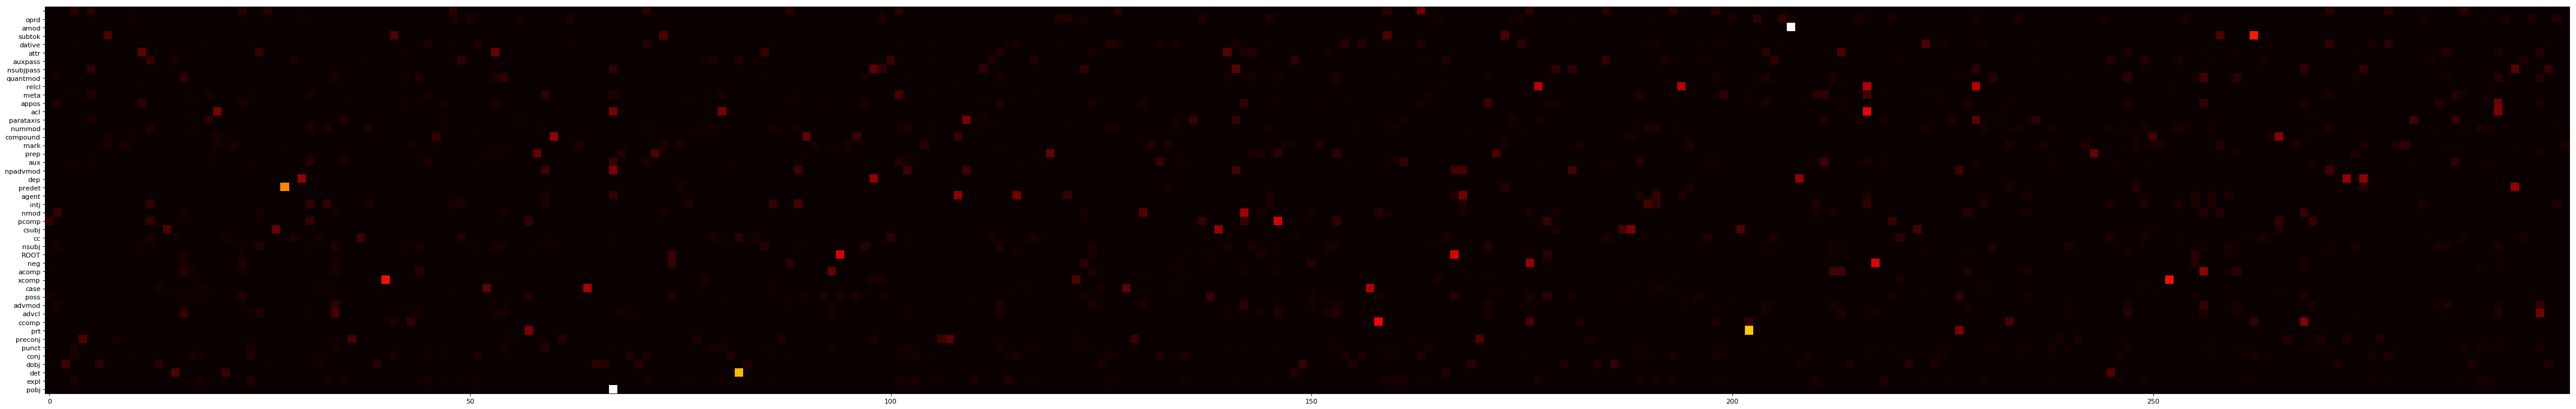

In [182]:
plot_heatmap(deps, labels_transformed)